## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [38]:
AbstractMatrix{Float64}

AbstractArray{Float64,2}

In [41]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [42]:
using DelimitedFiles

Load some packages to make nice figures

In [43]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [44]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [45]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [46]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [47]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [115]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [116]:
### Process and observation noise
σx = 1e-1
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [117]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [118]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Create cache to store the different final solutions

In [119]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [120]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [121]:
# writedlm( "lorenzdata.csv",  X, ',')
X = readdlm( "lorenzdata.csv",  ',')

6×500 Array{Float64,2}:
 12.6981    0.930478   3.98214  13.6515  …   5.38257    9.40037  -13.654
  8.37203   1.62649    5.75284  13.2089      0.775109   3.96774  -11.2277
 36.521    10.9611    17.4395   34.3492     29.3109    33.9116    36.3547
 12.6979    0.929687   3.98188  13.6506      5.38174    9.40014  -13.6549
  8.37175   1.62558    5.75274  13.2087      0.774492   3.96771  -11.2286
 36.5206   10.9604    17.4391   34.3489  …  29.3107    33.9112    36.354

In [126]:
# Initialize the map
m = 15
S = HermiteMap(m, X; diag = true, α = 1.0e-6)

HermiteMap(15, 6, LinearTransform(6, [-2.5757174171303633e-17, 2.0872192862952943e-17, -3.0819791163594343e-16, 1.5987211554602253e-17, 1.3322676295501878e-17, -2.6636470806806757e-15], [1.0000000000000002 0.0 … 0.0 0.0; 0.0 1.0000000000000007 … 0.0 0.0; … ; 0.0 0.0 … 1.0000000000000007 0.0; 0.0 0.0 … 0.0 0.9999999999999997], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [127]:
# plt = plot(layout = grid(6,1), size = (400, 800))

# for i=1:6
#       histogram!(plt[i,1], sort(transform(X)[i,:]), bins = 100; normalize = :pdf, legend = false)     
# end
# plt
# savefig("normalized_histogram.pdf")

The optimization works up to 22 active features, after the Cholesky decomposition crashes.

In [128]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = false, hessprecond = true)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  6.109583 seconds (2.87 M allocations: 8.400 GiB, 5.97% gc time)


HermiteMap(15, 6, LinearTransform(6, [-2.5757174171303633e-17, 2.0872192862952943e-17, -3.0819791163594343e-16, 1.5987211554602253e-17, 1.3322676295501878e-17, -2.6636470806806757e-15], [1.0000000000000002 0.0 … 0.0 0.0; 0.0 1.0000000000000007 … 0.0 0.0; … ; 0.0 0.0 … 1.0000000000000007 0.0; 0.0 0.0 … 0.0 0.9999999999999997], true), MapComponent[Map component of dimension 1 with Nψ 8 active features
, Map component of dimension 2 with Nψ 15 active features
, Map component of dimension 3 with Nψ 15 active features
, Map component of dimension 4 with Nψ 15 active features
, Map component of dimension 5 with Nψ 15 active features
, Map component of dimension 6 with Nψ 15 active features
])

In [129]:
# Conditioning number of the basis evaluation on the different samples
cond(evaluate_basis(S[1].I.f.f,  transform(X[1:1,:])))

145.6962198641177

In [130]:
stor = Storage(S[1].I.f, transform(X[1:1,:]))
q = QRscaling(stor)

QRscaling([-22.36067977499789 -0.7192395394428301 … 3.4873161041313496 1.2631359136158136; 0.0 -22.34910947856541 … -0.5960342430510774 2.231850829980256; … ; 0.0 0.0 … 2.3567764691736994 0.2627395987615587; 0.0 0.0 … 0.0 1.097671449658094], [-0.04472135954999581 0.0014392237899610886 … 0.14271114743145347 -0.04496039352748301; 0.0 -0.0447445121229139 … -0.030430900095526993 0.6689149400212294; … ; 0.0 0.0 … 0.4243083775995974 -0.10156282457415751; 0.0 0.0 … 0.0 0.9110194132419888], [0.525992748576151 0.0 … 0.0 0.0; 0.0 0.3836867233680237 … 0.0 0.0; … ; 0.0 0.0 … 0.25049854676258415 0.0; 0.0 0.0 … 0.0 0.2482548267582635], [1.9011668938535267 0.0 … 0.0 0.0; 0.0 2.6062929444676732 … 0.0 0.0; … ; 0.0 0.0 … 3.992039127267965 0.0; 0.0 0.0 … 0.0 4.0281190624089795], [-11.76155541488229 -0.27596266220554594 … 0.8735676161866597 0.31357958740683467; 0.0 -8.575056586024003 … -0.14930571170503176 0.554067741147035; … ; 0.0 0.0 … 0.5903690805722659 0.06522637357308642; 0.0 0.0 … 0.0 0.27250223557

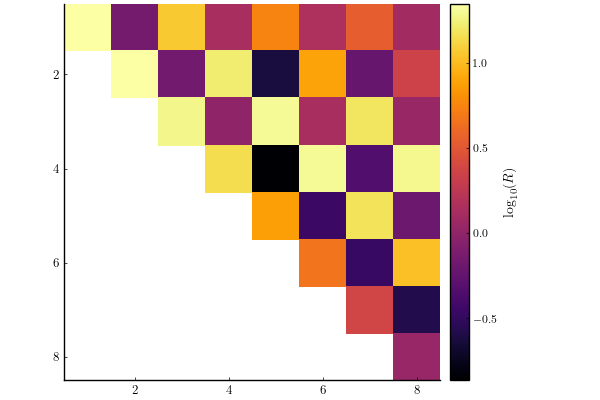

In [131]:
heatmap(log10.(abs.(q.R)), yflip =true, ratio = 1, colorbartitle = L"\log_{10}(R)")
# savefig("R_matrix.pdf")

In [132]:
cond(q.R)

111.73006949193426

In [133]:
getcoeff(S[3])

15-element Array{Float64,1}:
  35.51187238799568
 -43.564308952075834
  14.899585881834279
  11.53454046053177
  -1.8236444378717784
   8.139086978731166
  10.975789373608972
   1.252338304542764
 -17.547923343912135
   0.6750850688663297
  -7.670684267675492
   3.5462282298048673
   3.548580762105552
   0.7311032075995336
 -15.959955378860984

In [134]:
cond(evaluate_basis(S[6].I.f.f, X[1:6,:]))

6.411940680225215e6

In [135]:
P = zeros(ncoeff(S[1]), ncoeff(S[1]))
precond!(P, getcoeff(S[1]), stor, S[1], X[1:1,:])

Pqr = zeros(ncoeff(S[1]), ncoeff(S[1]))
qrprecond!(Pqr, q.U*getcoeff(S[1]), q, stor, S[1], X[1:1,:])

8×8 Array{Float64,2}:
  0.00242606   -3.50909e-5    0.000907718  …   0.000837029  -0.000192547
 -3.50909e-5    0.000659049  -7.60591e-5       1.19545e-5    0.000138426
  0.000907718  -7.60591e-5    0.000970218      0.00034957   -0.000101293
  1.91909e-5   -0.000210358  -4.27596e-5       0.000236013  -2.0862e-5
  0.000980056  -4.02052e-5    0.000282786     -0.000156415   0.00011482
 -0.00014898    0.000119361   3.78711e-5   …   0.000180977  -0.000865158
  0.000837029   1.19545e-5    0.00034957       0.00426429   -0.000261245
 -0.000192547   0.000138426  -0.000101293     -0.000261245   0.00542945

In [136]:
cond(P)

12274.637036520513

In [137]:
cond(Pqr)

12.509656132643213

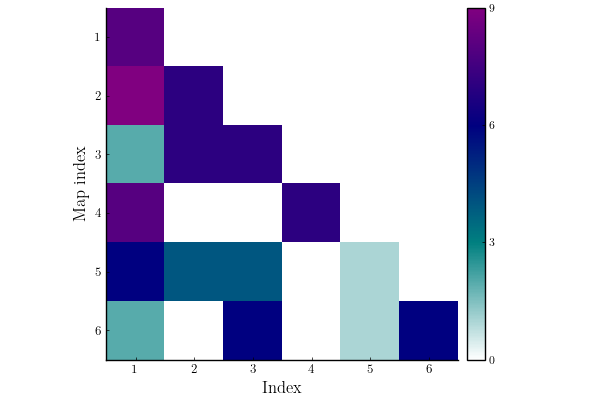

In [138]:
plot(S)

In [139]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
     2.07475e13      6.74276e7  57715.3         …    167.022  68566.2
     6.74276e7       5.09587e7  30888.5            67410.0        0.0
 57715.3         30888.5            2.7002e13       2247.69       2.69751e13
     2.05962e13      0.0            0.0                0.0        0.0
   167.022       67410.0         2247.69           84216.0     2784.29
 68566.2             0.0            2.69751e13  …   2784.29       2.70217e13

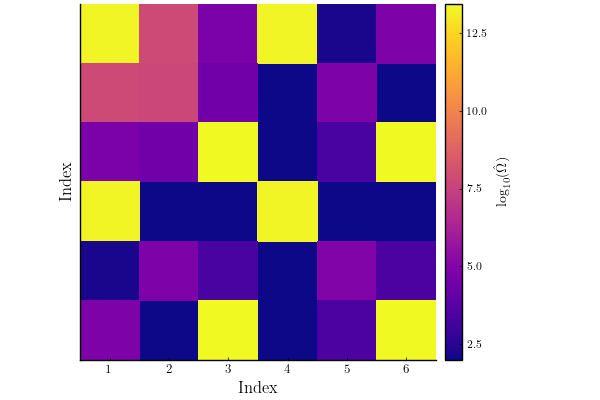

In [140]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

Set initial condition of the true system

In [141]:
x0 = rand(model.π0);

In [142]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [177]:
Ne = 500 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 -0.0905516  -1.80001    0.188729   …   0.434275  -1.53608    0.951554
  1.40524     0.915593  -0.0772391      1.0192    -1.12953   -0.438907
  0.153828    1.98426    0.144475      -0.147849   0.959539   0.752885

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [178]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)
tspin = 10.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

100

In [179]:
Xspin = seqassim(F, data, Tspin, model.ϵx, enkf, deepcopy(X), model.Ny, model.Nx, t0);

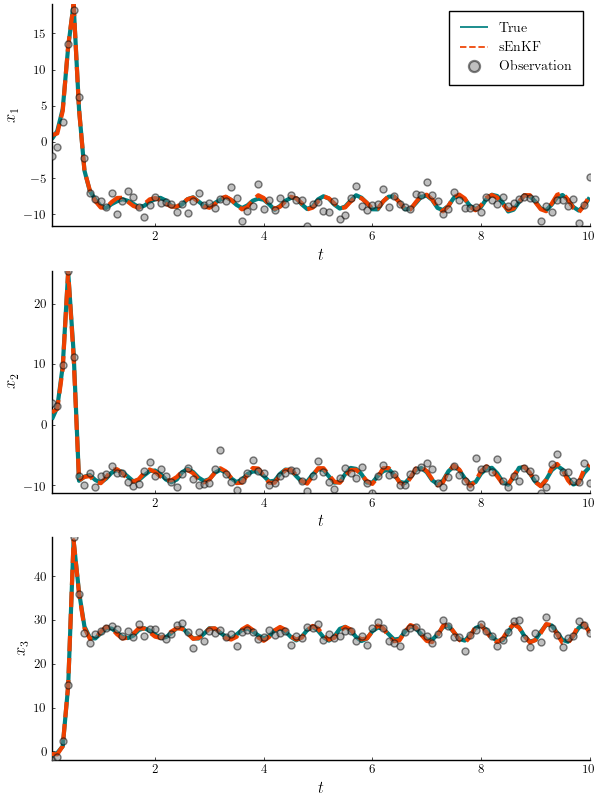

In [180]:
nb = 1
ne = Tspin
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xspin)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

Define the stochastic map filter `smf`, based on the `HermiteMap` `S`. 

In [198]:
X0 = vcat(zeros(Ny, Ne), Xspin[end])

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [199]:
m = 40
S = HermiteMap(m, X0; diag = true)

HermiteMap(40, 6, LinearTransform(6, [-7.401204086038835, -6.655771293362056, 27.144132191798636, -7.4928325955504524, -6.6514580032119355, 27.068509931111002], [1.0531327561940291 0.0 … 0.0 0.0; 0.0 1.0534926362741905 … 0.0 0.0; … ; 0.0 0.0 … 0.2838660817302922 0.0; 0.0 0.0 … 0.0 0.3148675361958246], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [200]:
@time optimize(S, X0, "kfolds"; withqr = true, verbose = true, hessprecond = true, start = Ny+1)

1 terms - Training error: 1.4292725870302316, Validation error: 1.3726023179024338
1 terms - Training error: 1.4291041120092653, Validation error: 1.373638555060744
2 terms - Training error: 1.4288127807315458, Validation error: 1.374953710085476
3 terms - Training error: 1.428113830682133, Validation error: 1.374192299355237
4 terms - Training error: 1.427369764512288, Validation error: 1.3711148918551113
5 terms - Training error: 1.4267341255159365, Validation error: 1.3687904327763494
6 terms - Training error: 1.4248666858101853, Validation error: 1.3612909558433397
7 terms - Training error: 1.424528141499165, Validation error: 1.3612812017710647
8 terms - Training error: 1.424389471510075, Validation error: 1.3624181082369962
9 terms - Training error: 1.424191542876531, Validation error: 1.3628319364920567
10 terms - Training error: 1.4162843046606872, Validation error: 1.3619118337809477
11 terms - Training error: 1.416182408939142, Validation error: 1.3619140369423843
12 terms - 

15 terms - Training error: 1.3624078817800735, Validation error: 1.4646576084778125
16 terms - Training error: 1.3610177420972425, Validation error: 1.479881647060227
17 terms - Training error: 1.357139447240481, Validation error: 1.462631571292143
18 terms - Training error: 1.353214342933821, Validation error: 1.4754877315343975
19 terms - Training error: 1.3519110446088665, Validation error: 1.4736664456870978
20 terms - Training error: 1.3516862986960947, Validation error: 1.470040825653214
21 terms - Training error: 1.3479944688813263, Validation error: 1.4755073837551205
22 terms - Training error: 1.3468462541950423, Validation error: 1.4786535295482566
23 terms - Training error: 1.3446327222832468, Validation error: 1.47387107002367
1 terms - Training error: 1.4179385332046723
1 terms - Training error: 1.4178903642154423
2 terms - Training error: 1.4146308280299411
3 terms - Training error: 1.4142142908833937
4 terms - Training error: 1.4139937075147035
5 terms - Training error: 

Progress:  33%|█████████████▋                           |  ETA: 0:00:06

23 terms - Training error: 1.3615328230591486
1 terms - Training error: 1.4194015013741388, Validation error: 1.4120866605268134
1 terms - Training error: 1.4193478985655696, Validation error: 1.4126663357618825
2 terms - Training error: 1.4185619027343364, Validation error: 1.4146616369714315
3 terms - Training error: 1.4175197271942037, Validation error: 1.413478606123769
4 terms - Training error: 1.3981986633138623, Validation error: 1.3799016230717516
5 terms - Training error: 1.3959213071218892, Validation error: 1.3758155802517393
6 terms - Training error: 1.3944091976337007, Validation error: 1.3754323876032535
7 terms - Training error: 1.393003521085343, Validation error: 1.3737152094901128
8 terms - Training error: 1.392545214656593, Validation error: 1.3747359752650519
9 terms - Training error: 1.389726944706038, Validation error: 1.3869388291938776
10 terms - Training error: 1.3893614476849117, Validation error: 1.3863772819465319
11 terms - Training error: 1.389094108011525

14 terms - Training error: 1.259295342175815, Validation error: 1.2789791880259624
15 terms - Training error: 1.2547667775717493, Validation error: 1.2688563874678809
16 terms - Training error: 1.2454472547350834, Validation error: 1.3083556338549094
17 terms - Training error: 1.2447794828106293, Validation error: 1.3126751632592069
18 terms - Training error: 1.2445456471466505, Validation error: 1.3138959944568265
19 terms - Training error: 1.242103632714299, Validation error: 1.3324854062417308
20 terms - Training error: 1.2415721440570946, Validation error: 1.327749069130159
21 terms - Training error: 1.23830241287916, Validation error: 1.3267000362441785
22 terms - Training error: 1.2381302647098495, Validation error: 1.3270619777985297
23 terms - Training error: 1.2316938847950962, Validation error: 1.2854292955612934
1 terms - Training error: 1.4179385332046741
1 terms - Training error: 1.4177872129717393
2 terms - Training error: 1.3950643238427083
3 terms - Training error: 1.39

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

23 terms - Training error: 1.240382284601927
24 terms - Training error: 1.2399001890686905
1 terms - Training error: 1.4449932021375196, Validation error: 1.3097198574732836
1 terms - Training error: 1.4448370900642447, Validation error: 1.309762245963975
2 terms - Training error: 1.3465198445970834, Validation error: 1.2715561115271456
3 terms - Training error: 1.3446165538999528, Validation error: 1.2745047516044057
4 terms - Training error: 1.3253963580348895, Validation error: 1.271867533123032
5 terms - Training error: 1.3249244898188004, Validation error: 1.2764755078942678
6 terms - Training error: 1.295110534196756, Validation error: 1.2875008911556494
7 terms - Training error: 1.2948446745900657, Validation error: 1.2878946921466943
8 terms - Training error: 1.288411532753426, Validation error: 1.296785611344556
9 terms - Training error: 1.2877102080265868, Validation error: 1.2944465585433262
10 terms - Training error: 1.2871571478645443, Validation error: 1.2973585632377673


15 terms - Training error: 1.2578724758127848, Validation error: 1.2889706197390647
16 terms - Training error: 1.2510302343981894, Validation error: 1.2831557007971204
17 terms - Training error: 1.2507170209882048, Validation error: 1.287649340805683
18 terms - Training error: 1.250092574027479, Validation error: 1.284749717119429
19 terms - Training error: 1.2488943246305644, Validation error: 1.280839529030211
20 terms - Training error: 1.2486847478056387, Validation error: 1.2815658554672549
21 terms - Training error: 1.248637180810553, Validation error: 1.279283416423833
22 terms - Training error: 1.2448828326400612, Validation error: 1.278638216974772
23 terms - Training error: 1.2414003476649196, Validation error: 1.2834254410239894
1 terms - Training error: 1.4179385332046721
1 terms - Training error: 1.4178194973779412
2 terms - Training error: 1.3311742972488398
3 terms - Training error: 1.3296019469682492
4 terms - Training error: 1.3293228217372404
5 terms - Training error: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


24 terms - Training error: 1.21299147372877
  8.834928 seconds (2.07 M allocations: 6.485 GiB, 4.07% gc time)


HermiteMap(40, 6, LinearTransform(6, [-7.401204086038835, -6.655771293362056, 27.144132191798636, -7.4928325955504524, -6.6514580032119355, 27.068509931111002], [1.0531327561940291 0.0 … 0.0 0.0; 0.0 1.0534926362741905 … 0.0 0.0; … ; 0.0 0.0 … 0.2838660817302922 0.0; 0.0 0.0 … 0.0 0.3148675361958246], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 23 active features
, Map component of dimension 5 with Nψ 24 active features
, Map component of dimension 6 with Nψ 24 active features
])

In [201]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, 4*Δtobs, false)

Stochastic Map Filter with filtered = false


In [202]:
mean(evaluate(S, X0; start = Ny+1); dims = 2)

6×1 Array{Float64,2}:
  0.0
  0.0
  0.0
 -3.268004104553812e-5
  6.032414585194967e-5
  0.00020295995512711228

In [203]:
cov(evaluate(S, X0; start = Ny+1); dims = 2)

6×6 Array{Float64,2}:
 0.0  0.0  0.0  0.0         0.0        0.0
 0.0  0.0  0.0  0.0         0.0        0.0
 0.0  0.0  0.0  0.0         0.0        0.0
 0.0  0.0  0.0  1.0017      0.0735239  0.00308688
 0.0  0.0  0.0  0.0735239   0.996943   0.0151309
 0.0  0.0  0.0  0.00308688  0.0151309  0.984909

In [204]:
Sxpush = evaluate(S, X0; start = Ny+1)[Ny+1:end,:]

3×500 Array{Float64,2}:
  2.81844    -0.542376  -0.15704   …   0.41102    0.0209882  -0.152696
  0.666549   -0.85898   -0.293812      1.14901   -0.317674   -1.66892
 -0.0569842  -0.648899   0.88822      -0.836627  -0.0561644   0.0919117

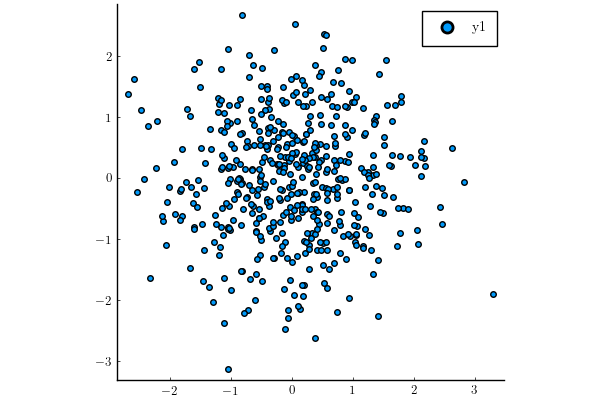

In [205]:
scatter(Sxpush[1,:], Sxpush[2,:], ratio = 1)
scatter(Sxpush[2,:], Sxpush[3,:], ratio = 1)
scatter(Sxpush[1,:], Sxpush[3,:], ratio = 1)

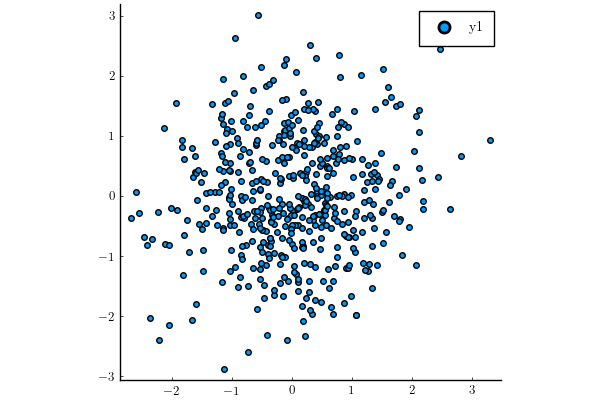

In [206]:
scatter(Sxpush[1,:], Sxpush[2,:], ratio = 1)

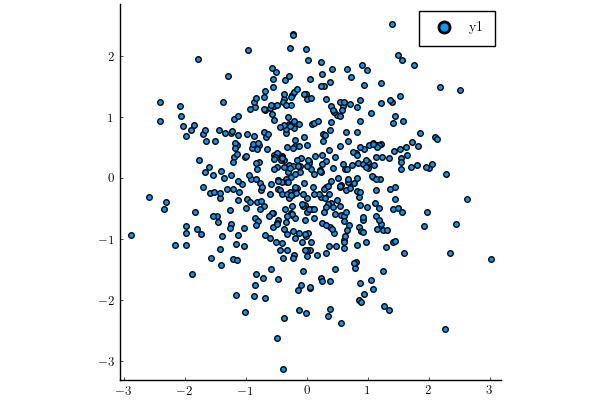

In [207]:
scatter(Sxpush[2,:], Sxpush[3,:], ratio = 1)

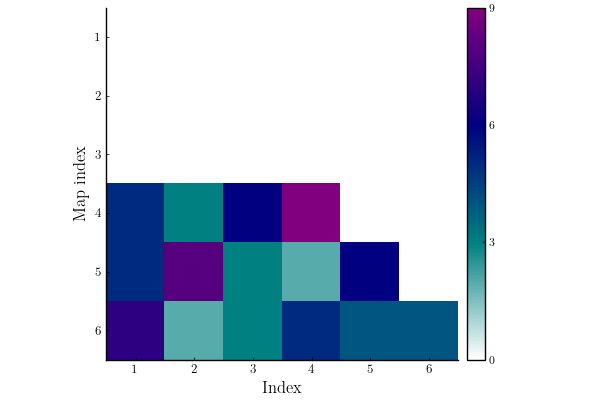

In [208]:
plot(S)

In [209]:
Xsmf = seqassim(F, data, 100, model.ϵx, smf, deepcopy(vcat(zeros(Ny, Ne), Xspin[end])), model.Ny, model.Nx, tspin)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

101-element Array{Array{Float64,2},1}:
 [-7.0675563443864275 -7.579740361552139 … -7.384580075571781 -7.628298347406498; -6.369670591661508 -7.043750175864433 … -6.67739847373347 -7.187686286109398; 26.806248035389274 26.818601223551163 … 26.90410049823504 27.055217046750332]
 [-6.352641823998095 -6.485573963910752 … -6.384210382101165 -6.684931767999972; -6.941017971319987 -6.849204869238212 … -6.968303469610504 -6.785050624770048; 24.601231549950434 24.963195570672553 … 25.007143459423506 24.994101706069923]
 [-7.268482959020534 -7.022433235381556 … -7.19005311205744 -7.173118137074814; -8.410171865179317 -8.64268280884557 … -8.42960827659375 -8.096826022647548; 23.967872095961617 23.9597577464858 … 24.28152326988049 24.145209537125677]
 [-8.294716832132517 -8.454526691434694 … -8.338502565759796 -8.291791657493517; -9.82460545984288 -9.728592312335604 … -9.63257639749605 -9.66324678905978; 24.7305822020086 24.601247044188792 … 24.604557884562887 24.47446575452778]
 [-9.7875570038194

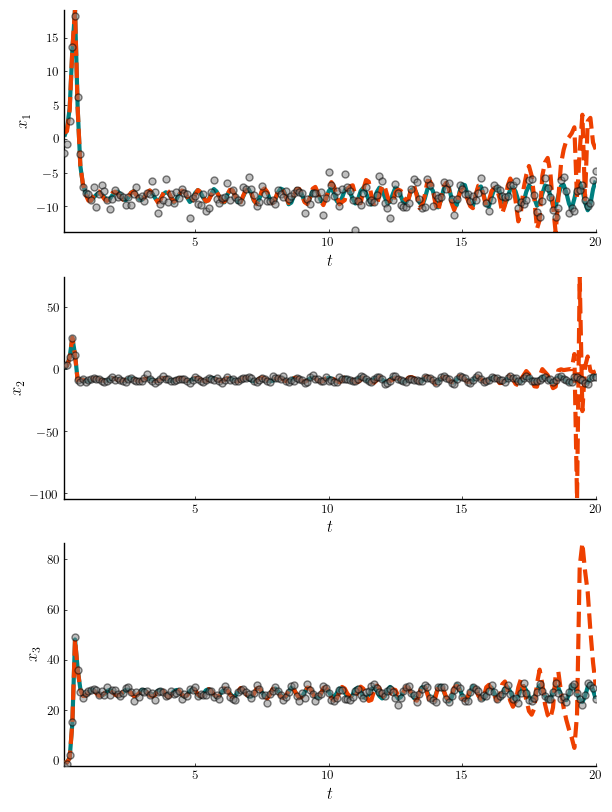

In [210]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = false, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

savefig("lorenz63_kfoldoptim.pdf")

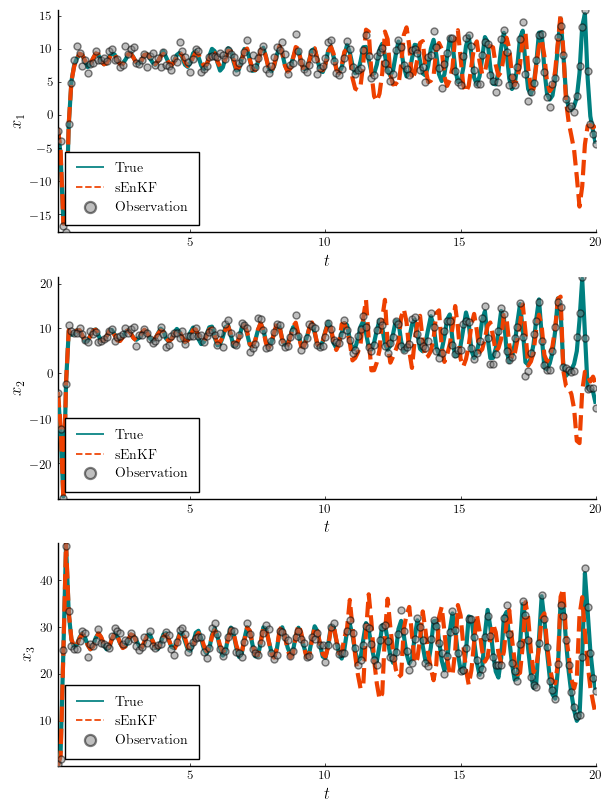

┌ Warning: /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent is not an existing directory, Revise is not watching
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:565


In [127]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

# savefig("lorenz63.pdf")

In [77]:
vcat(Xspin, Xsmf)

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [133]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×101 Array{Float64,2} at index [1, 2:1:500][39m

In [69]:
Xsmf

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl:4", UndefVarError(:TYPEDEF), Any[(top-level scope at system.jl:4, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl:52", UndefVarError(:TYPEDFIELDS), Any[(top-level scope at inflation.jl:52, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl:3", UndefVarError(:TYPEDSIGNATURES), Any[(top-level scope at etkf.jl:3, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Erro

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.